In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

In [2]:
X_train = pickle.load(open('Data/X_train.pkl', 'rb'))
y_train = pickle.load(open('Data/y_train.pkl', 'rb'))
X_test = pickle.load(open('Data/X_test.pkl', 'rb'))
y_test = pickle.load(open('Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(329, 20530)
(329,)
(83, 20530)
(83,)


In [3]:
# standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[-0.48855657  0.12112708 -0.33372349 ...  0.04735987  0.50779996
  -0.02217494]
 [ 0.83092164  1.17948768 -0.33372349 ...  0.18754437  0.77965228
  -0.17205193]
 [-1.861054   -0.69352094 -0.33372349 ... -0.35346398 -2.00005787
   3.63814136]
 ...
 [ 1.50287947  0.88173571  0.1048791  ... -0.33180584  0.91213697
  -0.14253948]
 [-0.06583194  0.60359346 -0.33372349 ...  0.20030191  0.44110666
  -1.31512921]
 [-0.87784052 -0.01478846 -0.33372349 ...  0.12805867  1.46177518
  -0.6430939 ]]


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([329, 20530]),
 torch.Size([83, 20530]),
 torch.Size([329]),
 torch.Size([83]))

In [6]:
# define an autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, encoding_dim),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.ReLU(True)
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

In [7]:
encoding_dim = 32

encoder = Autoencoder(input_dim=20530, encoding_dim=encoding_dim)
encoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=20530, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=20530, bias=True)
    (5): ReLU(inplace=True)
  )
)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

# train the autoencoder
epochs = 100
batch_size = 32

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        
        inputs = X_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = encoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.item()))

epoch [1/100], loss:1.1029
epoch [2/100], loss:1.0469
epoch [3/100], loss:1.0166
epoch [4/100], loss:0.9763
epoch [5/100], loss:0.9708
epoch [6/100], loss:0.9545
epoch [7/100], loss:0.9374
epoch [8/100], loss:0.9505
epoch [9/100], loss:0.9692
epoch [10/100], loss:0.9213
epoch [11/100], loss:0.8807
epoch [12/100], loss:0.8639
epoch [13/100], loss:0.8460
epoch [14/100], loss:0.8328
epoch [15/100], loss:0.8623
epoch [16/100], loss:0.8738
epoch [17/100], loss:0.8551
epoch [18/100], loss:0.8174
epoch [19/100], loss:0.8022
epoch [20/100], loss:0.7950
epoch [21/100], loss:0.7830
epoch [22/100], loss:0.7769
epoch [23/100], loss:0.7666
epoch [24/100], loss:0.7525
epoch [25/100], loss:0.7493
epoch [26/100], loss:0.7537
epoch [27/100], loss:0.7511
epoch [28/100], loss:0.7657
epoch [29/100], loss:0.7923
epoch [30/100], loss:0.7738
epoch [31/100], loss:0.7719
epoch [32/100], loss:0.7572
epoch [33/100], loss:0.7597
epoch [34/100], loss:0.7472
epoch [35/100], loss:0.7454
epoch [36/100], loss:0.7338
e

In [12]:
with torch.no_grad():
    test_enc = encoder.encode(X_test.to(device)).cpu()
    test_dec = encoder.decode(test_enc).cpu()

    test_mse = criterion(test_dec, X_test).item()
    print('MSE: {:.4f}'.format(test_mse))

MSE: 0.9691


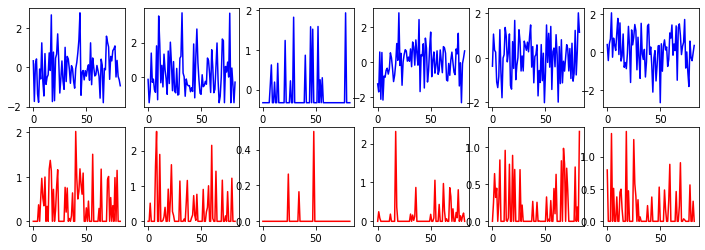

In [13]:
# randomly choose 6 features from both the original and reconstructed data
# and plot them
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))

for i in range(6):
    axes[0, i].plot(X_test[:, i].numpy(), color='blue')
    axes[1, i].plot(test_dec[:, i].numpy(), color='red')

plt.show()

MSE: 0.6255


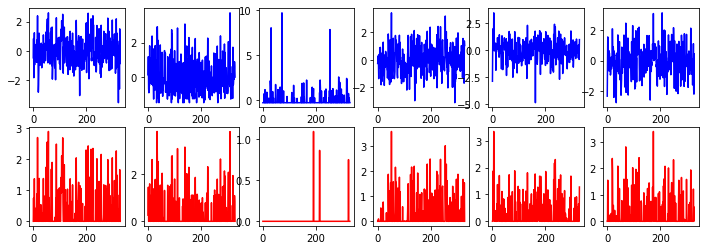

In [14]:
with torch.no_grad():
    train_enc = encoder.encode(X_train.to(device)).cpu()
    train_dec = encoder.decode(train_enc).cpu()

    train_mse = criterion(train_dec, X_train).item()
    print('MSE: {:.4f}'.format(train_mse))


fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))

for i in range(6):
    axes[0, i].plot(X_train[:, i].numpy(), color='blue')
    axes[1, i].plot(train_dec[:, i].numpy(), color='red')

plt.show()

In [12]:
encoder_model = {
    'encoder': encoder,
    'enc_dim': encoding_dim,
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_enc': train_enc,
    'test_enc': test_enc,
}

pickle.dump(encoder_model, open('Data/encoder_model.pkl', 'wb'))

In [ ]:
pickle.dump(encoder, open('Data/encoder.pkl', 'wb'))

In [45]:
pickle.dump(train_enc, open('Data/train_enc.pkl', 'wb'))
pickle.dump(test_enc, open('Data/test_enc.pkl', 'wb'))